## generate previous frames with pCO2 and fit it against ConvLSTM for multiple members

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2023-09-10 12:24:36.967359: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.13.5


###  CESM Previous Frame generation

In [4]:
dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)

def custom_rmse2(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    + difference between sss
    """
    idx  = tf.not_equal(y_true, 0.0)
    idx2  = tf.equal(y_true, 0.0)
    
    y_pred1 = tf.boolean_mask(y_pred,idx)
    y_true1 = tf.boolean_mask(y_true,idx)
    y_true1 = tf.cast(y_true1, y_pred.dtype)
    
    
    return rmse1


In [5]:
# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
             "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


/burg/glab/users/sk4973/venv2/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [6]:
INPUT_SHAPE=X_all[0].shape
OUTPUT_SHAPE=y_all[0].shape

INPUT_SHAPE, X_all.shape, y_all.shape

((180, 360, 5), (421, 180, 360, 5), (421, 180, 360))

#### train

In [7]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")

base_model = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.Dropout(0.2),
    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
])

myLearnRate=0.0005
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)

#rmse 13



base_model.compile(loss=custom_rmse, optimizer=custom_opt)

2023-09-10 12:24:46.255927: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-09-10 12:24:46.257102: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-09-10 12:24:46.317374: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Tesla V100S-PCIE-32GB computeCapability: 7.0
coreClock: 1.597GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 1.03TiB/s
2023-09-10 12:24:46.317429: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-09-10 12:24:46.320812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-10 12:24:46.320896: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2

In [8]:


model_path="../../models/base_model/u_net_dist.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = base_model.fit(X_all,y_all, epochs=200, 
                         validation_data=(X_all,y_all),
                         workers=-1,batch_size=16,
                         callbacks=callbacks)




2023-09-10 12:24:53.390071: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-09-10 12:24:53.403689: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900000000 Hz


Epoch 1/200


2023-09-10 12:24:54.094545: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2023-09-10 12:24:55.527449: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-09-10 12:24:55.804374: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


27/27 [==============================] - 9s 189ms/step - loss: 65.6709 - val_loss: 17.6982
Epoch 2/200
27/27 [==============================] - 3s 117ms/step - loss: 18.9983 - val_loss: 16.6158
Epoch 3/200
27/27 [==============================] - 3s 117ms/step - loss: 15.6905 - val_loss: 14.2345
Epoch 4/200
27/27 [==============================] - 3s 117ms/step - loss: 13.3973 - val_loss: 12.0044
Epoch 5/200
27/27 [==============================] - 3s 116ms/step - loss: 11.1967 - val_loss: 9.5864
Epoch 6/200
27/27 [==============================] - 3s 117ms/step - loss: 9.4747 - val_loss: 9.5329
Epoch 7/200
 1/27 [>.............................] - ETA: 2s - loss: 9.0008

KeyboardInterrupt: 

#### load model

In [9]:
cnn_model = tf.keras.models.load_model('../../models/base_model/u_net_dist_final.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image= cnn_model.predict(X_all,verbose=1)
predicted_image[y_all==0]=0.0

14/14 [==============================] - 1s 45ms/step


(array([1.0010754e+07, 3.6302500e+05, 2.0546840e+06, 1.1640878e+07,
        2.9447960e+06, 2.2366000e+05, 3.0184000e+04, 9.1380000e+03,
        3.2130000e+03, 4.6800000e+02]),
 array([ -0.80052453,  23.543337  ,  47.8872    ,  72.231064  ,
         96.57492   , 120.918785  , 145.26265   , 169.6065    ,
        193.95036   , 218.29424   , 242.63809   ], dtype=float32),
 <BarContainer object of 10 artists>)

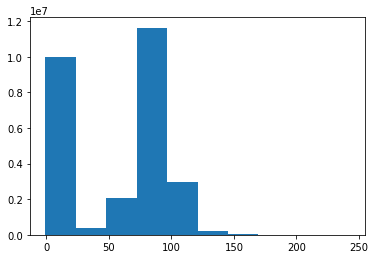

In [10]:
plt.hist(predicted_image.flatten())

In [8]:
print(custom_rmse(predicted_image,y_all))

tf.Tensor(2.958678461381212, shape=(), dtype=float64)


In [12]:

y_true_all = np.empty((0,180,360))
y_pred_all = np.empty((0,180,360))


for i in range(3):
    tmp = i+1
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(dir_name,num =data_nums[i])
    y_true,y_pred = inverse_scale_image(predicted_image[421*(tmp-1):421*tmp],pco2t2.pCO2.data)
    y_true_all = np.concatenate((y_true_all, y_true))
    y_pred_all = np.concatenate((y_pred_all, y_pred))


print("y_shapes:", y_true_all.shape, y_pred_all.shape)
print("Full RMSE score:")
a=custom_rmse(y_pred_all,y_true_all)
print(a.numpy())


### Using the prediction as input in ConvLSTM

In [76]:
K = 1
X_all_conv = np.empty((0, K, 180, 360, 6))
y_all_conv = np.empty((0, K, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),K)

tmp = 1

for i in range(1):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image[421*(tmp-1):421*tmp]))
    tmp+=1
    X = X.reshape((421,180,360,6),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((420, 1, 180, 360, 6), (420, 1, 180, 360, 1))

In [77]:
INPUT_SHAPE=X_all_conv[0].shape
OUTPUT_SHAPE=y_all_conv[0].shape

INPUT_SHAPE

(1, 180, 360, 6)

#### Train

In [78]:
tf.keras.backend.clear_session()
from functools import partial


DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)



model = keras.models.Sequential([
    DefaultConvLSTM2D(input_shape=INPUT_SHAPE),
    DefaultConvLSTM2D(kernel_size=(4,4)),
    keras.layers.BatchNormalization(),
    DefaultConvLSTM2D(kernel_size=(2,2)),
    keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),activation="elu", padding="same")
    
])


model.compile(
    loss=custom_rmse, optimizer=keras.optimizers.Adam(
        learning_rate=0.001),
)

In [79]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 1, 180, 360, 32)   121728    
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 180, 360, 32)   131200    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 180, 360, 32)   128       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 180, 360, 32)   32896     
_________________________________________________________________
conv3d (Conv3D)              (None, 1, 180, 360, 1)    865       
Total params: 286,817
Trainable params: 286,753
Non-trainable params: 64
_________________________________________________________________


In [ ]:
model_path=f"../../models/ConvLSTM_with_pco2_{K}mon.h5"

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 50
batch_size = 8

# Fit the model to the training data.
hist = model.fit(
    X_all_conv,
    y_all_conv,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_all_conv,y_all_conv),
    callbacks=callbacks,
)

Epoch 1/50
53/53 [==============================] - 27s 383ms/step - loss: 78.4828 - val_loss: 111.5323
Epoch 2/50
53/53 [==============================] - 19s 355ms/step - loss: 11.0852 - val_loss: 12.8338
Epoch 3/50
53/53 [==============================] - 19s 357ms/step - loss: 8.3139 - val_loss: 12.4208
Epoch 4/50
53/53 [==============================] - 19s 357ms/step - loss: 7.7469 - val_loss: 19.5186
Epoch 5/50
53/53 [==============================] - 19s 358ms/step - loss: 7.1362 - val_loss: 21.5166
Epoch 6/50
53/53 [==============================] - 19s 358ms/step - loss: 6.7673 - val_loss: 16.5844
Epoch 7/50
53/53 [==============================] - 19s 358ms/step - loss: 6.6387 - val_loss: 14.8207
Epoch 8/50
53/53 [==============================] - 19s 358ms/step - loss: 6.5147 - val_loss: 16.3115
Epoch 9/50
53/53 [==============================] - 19s 358ms/step - loss: 6.3363 - val_loss: 10.6642
Epoch 10/50
53/53 [==============================] - 19s 358ms/step - loss: 6.3

In [ ]:
# the masking continents for continent works better for pretrained model

### Result for CONVLSTM

In [ ]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [ ]:
convlstm_model_path = f"../../models/ConvLSTM_with_pco2_{K}mon.h5"
convlstm_model = tf.keras.models.load_model(convlstm_model_path, custom_objects={'custom_rmse':custom_rmse})

In [ ]:

dir_name = "../../data/member_009"
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2t2 = read_xarray(
    dir_name,num="009")

tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])

y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)
coord = (y_true_full==0.0)

chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
y1 = preprocess_image_reduced(pco2t2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X1 = X1.reshape((421,180,360,5),order='F')

predicted_image= cnn_model.predict(X1,verbose=1)
predicted_image[y1==0]=0.0


X_tmp = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images,predicted_image))
X_tmp= X_tmp.reshape((421,180,360,6),order='F')


X2 = X_tmp[X_index][:-1]

X2.shape

In [ ]:
predicted_frames = convlstm_model.predict(X2)

y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2t2.pCO2.data)  
y_pred[coord]=0.0
y_true[coord]=0.0

print("Full RMSE score:")
a=custom_rmse(y_true[:,K-1],y_pred[:,K-1]) # RMSE 3 month: 14.52 # RMSE 6 month: 13.133677
print(a)


In [ ]:
y1=y1[X_index][:-1]
y1 = np.expand_dims(y1,axis=4)
y1.shape

In [ ]:
predicted_frames.shape

In [ ]:
predicted_frames[:,K-1].shape

In [ ]:
y_true[coord]=np.nan
y_pred[coord]=np.nan

res = y_true[:,K-1]-y_pred[:,K-1]

avg_time_res_convlstm = np.nanmean(res, axis=(1,2,3))
print(avg_time_res_convlstm.shape)

fig = pyplot.figure(figsize = (10,10))
pyplot.subplot(211)
plot_acf(avg_time_res_convlstm, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(avg_time_res_convlstm, ax=pyplot.gca())

fig.suptitle(f"Residual ACF & PACF for ConvLSTM {K} month- CESM")

plt.savefig(f"../../assets/figure7_convLSTM_cesm_acf_{K}mon.jpg")
pyplot.show()

In [ ]:
xlabels = []
start_year = 2000

for i in range(len(avg_time_res_convlstm[218:])):
    if i%12==0:
        xlabels.append(str(start_year))
        start_year+=1
    else:
        xlabels.append("")

In [ ]:
fig = pyplot.figure(figsize = (20,5))
plt.plot(avg_time_res_convlstm[218:])
plt.xticks(ticks=range((415-218)),labels=xlabels,rotation=40)
plt.axhline(y = 0.0,color = 'r', linestyle = '-')
fig.suptitle(f"ConvLSTM {K} month - Residual over Time")
plt.savefig(f"../../assets/figure7_convLSTM_residual_{K}mon.jpg")
plt.show()

In [ ]:
np.mean(avg_time_res_convlstm), np.var(avg_time_res_convlstm)
# 3 mon: (0.19049866223339668, 4.744850814381859)
# 6 mon: (0.08857827863591704, 3.2171045340551534)